In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [46]:
# build the dataset

block_size = 3 # context length; how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [47]:
X.shape, X.dtype

(torch.Size([228146, 3]), torch.int64)

In [9]:
# lookup table C
# 17000 -> 30 (in the paper)
# we: 27 -> 2
C = torch.randn((27, 2))
C[5]

tensor([-0.2080,  1.8524])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.2080,  1.8524])

In [11]:
emb = C[X]

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [13]:
# emb @ W1 + b1 does not work because shapes are not compatible

In [14]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [15]:
# storage offsets, strides, shapes
# how tensors are represented 
# .storage(), .view()

In [16]:
emb.view(32, 6)

tensor([[-2.3784,  1.2543, -2.3784,  1.2543, -2.3784,  1.2543],
        [-2.3784,  1.2543, -2.3784,  1.2543, -0.2080,  1.8524],
        [-2.3784,  1.2543, -0.2080,  1.8524, -0.4711,  0.6547],
        [-0.2080,  1.8524, -0.4711,  0.6547, -0.4711,  0.6547],
        [-0.4711,  0.6547, -0.4711,  0.6547, -1.3714,  1.3324],
        [-2.3784,  1.2543, -2.3784,  1.2543, -2.3784,  1.2543],
        [-2.3784,  1.2543, -2.3784,  1.2543,  2.6259,  0.8076],
        [-2.3784,  1.2543,  2.6259,  0.8076,  0.2539,  2.3258],
        [ 2.6259,  0.8076,  0.2539,  2.3258, -0.8255, -0.3556],
        [ 0.2539,  2.3258, -0.8255, -0.3556,  0.9829,  0.0901],
        [-0.8255, -0.3556,  0.9829,  0.0901, -0.8255, -0.3556],
        [ 0.9829,  0.0901, -0.8255, -0.3556, -1.3714,  1.3324],
        [-2.3784,  1.2543, -2.3784,  1.2543, -2.3784,  1.2543],
        [-2.3784,  1.2543, -2.3784,  1.2543, -1.3714,  1.3324],
        [-2.3784,  1.2543, -1.3714,  1.3324,  0.9829,  0.0901],
        [-1.3714,  1.3324,  0.9829,  0.0

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [18]:
h.shape

torch.Size([32, 100])

In [19]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2

In [21]:
logits.shape

torch.Size([32, 27])

In [22]:
counts = logits.exp()

In [23]:
prob = counts / counts.sum(1, keepdims=True)

In [24]:
prob.shape

torch.Size([32, 27])

In [25]:
loss = -prob[torch.arange(32), Y].log().mean()

In [209]:
## rewrite it
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [210]:
sum(p.nelement() for p in parameters)

11897

In [207]:
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
logits = h @ W2 + b2 # 32, 27
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (913125x6 and 30x200)

In [208]:
F.cross_entropy(logits, Y)

ValueError: Expected input batch_size (32) to match target batch_size (182625).

In [194]:
torch.tensor(90).exp()

tensor(inf)

In [211]:
for p in parameters:
    p.requires_grad = True

In [196]:
lrs = 10**torch.linspace(-3, 0, 1000)


In [212]:
X, Y = Xtr, Ytr

lri = []
lossi = []
stepi = []

In [224]:
for i in range(50000):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32, )) # but have approximate gradient
    
    # forward pass
    emb = C[X[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    lr = 0.01 # start with 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    #lri.append(lr)
    #lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())

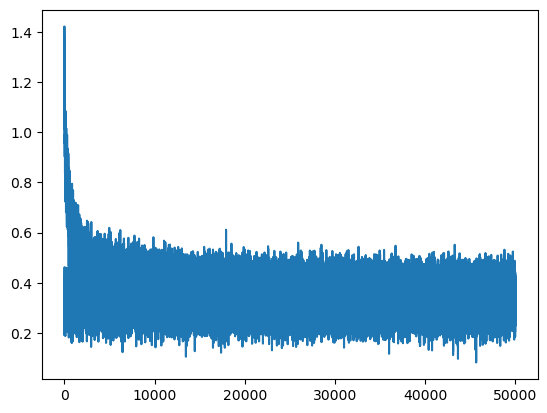

In [225]:
plt.plot(stepi, lossi) # "thick because minibatch size is small"

In [226]:
# overall loss
# now dev loss
X, Y = Xdev, Ydev
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

# 2.3 is 'dramatically' improving over the 2.45 over the bigram model

2.0691895484924316


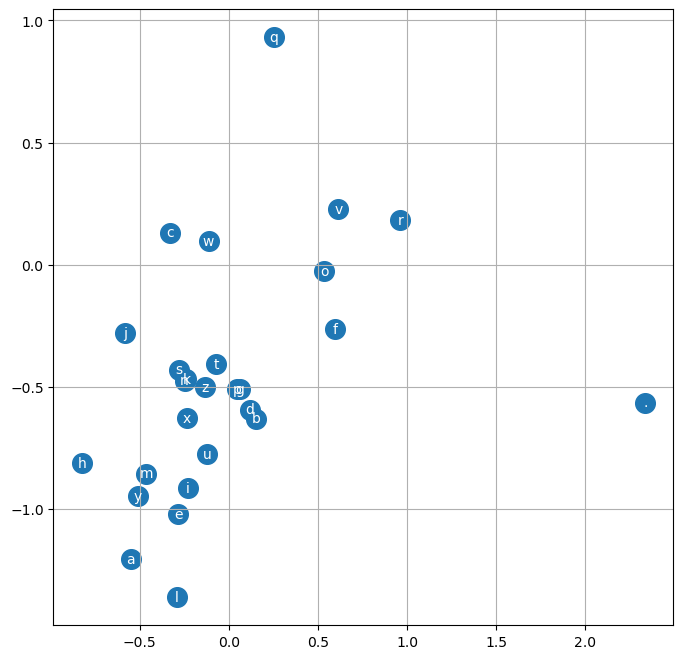

In [230]:
# visualize embedding
dim1, dim2 = 0, 3
plt.figure(figsize=(8,8))
plt.scatter(C[:, dim1].data, C[:, dim2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, dim1].item(), C[i, dim2].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [141]:
# train, dev/validation, test splits, 80/10/10
# train: parameters
# dev: hyperparameters
# test: evaluate model (use sparingly)

In [143]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train, dev, test
Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [231]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzato.
hari.
kimly.
reigh.
skanys.
corrhanna.
perric.
kaqmison.
mari.
chaiiv.
kaleigh.
ham.
poin.
quint.
shoin.
aliiani.
wavero.
dearystift.
ezlively.
edde.
